In [1]:
from dotenv import load_dotenv
import os
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_anthropic import ChatAnthropic
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

load_dotenv()



True

### Agent State

In [2]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    llm_call_count: int = 0
    ticket_details:str = ""
    issue_analysis:str = ""

### Structured Output for Ticket details

In [3]:
class TicketDetails(BaseModel):
    """for capturing ticket details from given data"""
    application_name: str = Field(description="captures the application name from given data, if application name is not found then set it to 'application_not_found'")


### Tools (mocking the API call response) 

In [4]:
@tool
def get_ticket_details(ticket_number:str)->str:
    """Check the incident details for given ticket number."""
    if ticket_number == "INC12345":
        return "{'id':'INC12345','environment':'prod', 'date':'07072024', 'application_name':'transaction-api'}"
    else:
        return "{'id':'INC123456','environment':'uat', 'date':'07142024', 'application_name':'order-api'}"

@tool  
def get_log_details(appliccation_name:str)->str:
    """Check the application logs for given application name"""
    if "transaction-api" in appliccation_name:
        return """
        2024-06-27 10:00:00.000  INFO 12345 --- [main] com.example.demo.TransactionApi         : Starting TransactionApi on user-macbook with PID 12345 (/path/to/demo-0.0.1-SNAPSHOT.jar started by user in /path/to/spring-boot-app)
        2024-06-27 10:00:00.001  INFO 12345 --- [main] com.example.demo.TransactionApi         : No active profile set, falling back to default profiles: default
        2024-06-27 10:00:01.123  INFO 12345 --- [main] o.s.b.w.embedded.tomcat.TomcatWebServer  : Tomcat initialized with port(s): 8080 (http)
        2024-06-27 10:00:01.456  INFO 12345 --- [main] o.apache.catalina.core.StandardService   : Starting service [Tomcat]
        2024-06-27 10:00:01.456  INFO 12345 --- [main] o.apache.catalina.core.StandardEngine    : Starting Servlet engine: [Apache Tomcat/9.0.37]
        2024-06-27 10:00:02.789  INFO 12345 --- [main] o.s.b.w.servlet.ServletRegistrationBean  : Servlet dispatcherServlet mapped to [/]
        2024-06-27 10:00:03.123  INFO 12345 --- [main] o.s.b.w.embedded.tomcat.TomcatWebServer  : Tomcat started on port(s): 8080 (http) with context path ''
        2024-06-27 10:00:03.456  INFO 12345 --- [main] com.example.demo.TransactionApi         : Started TransactionApi in 3.456 seconds (JVM running for 4.789)
        2024-06-27 10:00:04.123  ERROR 12345 --- [main] com.example.demo.OutOfMemorySimulator    : OutOfMemoryError: Java heap space
        java.lang.OutOfMemoryError: Java heap space
        at com.example.demo.OutOfMemorySimulator.simulateOutOfMemory(OutOfMemorySimulator.java:12) ~[classes/:na]
        at com.example.demo.TransactionApi.main(TransactionApi.java:11) ~[classes/:na]
        """
    else :
        return """
        2024-06-27 11:00:00.000  INFO 12345 --- [main] com.example.demo.OrderApi         : Starting OrderApi on user-macbook with PID 12345 (/path/to/demo-0.0.1-SNAPSHOT.jar started by user in /path/to/spring-boot-app)
        2024-06-27 11:00:00.001  INFO 12345 --- [main] com.example.demo.OrderApi         : No active profile set, falling back to default profiles: default
        2024-06-27 11:00:01.123  INFO 12345 --- [main] o.s.b.w.embedded.tomcat.TomcatWebServer  : Tomcat initialized with port(s): 8080 (http)
        2024-06-27 11:00:01.456  INFO 12345 --- [main] o.apache.catalina.core.StandardService   : Starting service [Tomcat]
        2024-06-27 11:00:01.456  INFO 12345 --- [main] o.apache.catalina.core.StandardEngine    : Starting Servlet engine: [Apache Tomcat/9.0.37]
        2024-06-27 11:00:02.789  INFO 12345 --- [main] o.s.b.w.servlet.ServletRegistrationBean  : Servlet dispatcherServlet mapped to [/]
        2024-06-27 11:00:03.123  INFO 12345 --- [main] o.s.b.w.embedded.tomcat.TomcatWebServer  : Tomcat started on port(s): 8080 (http) with context path ''
        2024-06-27 11:00:03.456  INFO 12345 --- [main] com.example.demo.OrderApi         : Started OrderApi in 3.456 seconds (JVM running for 4.789)
        2024-06-27 11:00:04.123  ERROR 12345 --- [main] com.example.demo.NullPointerSimulator    : NullPointerException: Cannot invoke "String.length()" because "str" is null
        java.lang.NullPointerException: Cannot invoke "String.length()" because "str" is null
        at com.example.demo.NullPointerSimulator.simulateNullPointer(NullPointerSimulator.java:12) ~[classes/:na]
        at com.example.demo.OrderApi.main(OrderApi.java:11) ~[classes/:na]
        """
tool_mapping = {"get_ticket_details": get_ticket_details, "get_log_details":get_log_details}


### LLM initialization

In [5]:
#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620",temperature=0)
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
llm_with_tools = llm.bind_tools([get_ticket_details, get_log_details])
llm_with_stuctured_output = llm.with_structured_output(TicketDetails)

### Node and edge functions 

In [6]:
def summarize_ticket_details(state:AgentState):
    messages = state["messages"]
    if isinstance(messages[-1],ToolMessage):
        ticket_details = llm_with_stuctured_output.invoke(messages)
        response = AIMessage(content="application_name="+ticket_details.application_name)
        #print("response : ",response) 
    else:
        response = llm_with_tools.invoke(messages)   
    state["llm_call_count"] += 1
    return {"messages": [response], "llm_call_count": state["llm_call_count"]}

def get_ticket_details_tool(state:AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    #print("Tool output:", tool_output)
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "llm_call_count": state["llm_call_count"], "ticket_details":tool_output}

def should_make_ticket_details_tool_call(state:AgentState):
    #print("STATE:", state)
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "no_move_to_log_processing"
    else:
        return "yes_ticket_details_requested"

def process_log_details(state:AgentState):
    messages = state["messages"]
    last_messages = messages[-1]
    if isinstance(last_messages,AIMessage):
        log_summarization_message = HumanMessage(content="for application name identified in previous conversation fetch the logs and perform basic analysis to determine if spring boot application has any issue, provide concise summary if any issue is found")
        messages.append(log_summarization_message)
        
    response = llm_with_tools.invoke(messages)
    state["llm_call_count"] += 1
    return {"messages": [response], "llm_call_count": state["llm_call_count"],"issue_analysis":response.content}

def get_log_details_tool(state:AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    #print("Tool output:", tool_output)
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "llm_call_count": state["llm_call_count"]}

def should_make_log_details_tool_call(state:AgentState):
    #print("STATE:", state)
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "no_move_to_final_summary_step"
    else:
        return "yes_log_details_requested"

In [7]:
print("starting execution")

 #tools
#print(get_ticket_details("INC12345"))
#print(get_log_details("transaction-api"))
    
#dag initialization
check_incident_workflow = StateGraph(AgentState)

#Nodes
check_incident_workflow.add_node("summarize_ticket_details",summarize_ticket_details)
check_incident_workflow.add_node("get_ticket_details_tool",get_ticket_details_tool)
check_incident_workflow.add_node("process_log_details",process_log_details)
check_incident_workflow.add_node("get_log_details_tool",get_log_details_tool)

#dag formation
check_incident_workflow.add_conditional_edges(
    "summarize_ticket_details",
    should_make_ticket_details_tool_call,
    {
            "yes_ticket_details_requested":"get_ticket_details_tool",
            "no_move_to_log_processing":"process_log_details"
    }
)

check_incident_workflow.add_edge("get_ticket_details_tool","summarize_ticket_details")

check_incident_workflow.add_conditional_edges(
    "process_log_details",
    should_make_log_details_tool_call,
    {
        "yes_log_details_requested":"get_log_details_tool",
        "no_move_to_final_summary_step":END
    }
)
check_incident_workflow.add_edge("get_log_details_tool","process_log_details")

check_incident_workflow.set_entry_point("summarize_ticket_details")
app = check_incident_workflow.compile()

#dag execution 
system_message = SystemMessage(
    content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again"
)
human_message = HumanMessage(content="please check details for ticket INC123456, from the details identify the application name and return it. If application name is not present then return 'application_not_found'.")
messages = [system_message, human_message]

result = app.invoke({"messages": messages, "llm_call_count": 0})
print("\n##################\n# Ticket_details #\n##################\n")
print(result["ticket_details"],"\n")
print("\n##################\n# Issue Analysis #\n##################\n")
print(result["issue_analysis"],"\n\n")
print("llm call count : ", result["llm_call_count"])

starting execution

##################
# Ticket_details #
##################

{'id':'INC123456','environment':'uat', 'date':'07142024', 'application_name':'order-api'} 


##################
# Issue Analysis #
##################

**Summary of Log Analysis for OrderApi:**

- The application started successfully on port 8080.
- However, there is a critical issue identified:
  - A `NullPointerException` occurred, indicating that the application attempted to invoke the `length()` method on a null string. This error is logged at `2024-06-27 11:00:04.123`.

**Conclusion:** The Spring Boot application has a significant issue due to a `NullPointerException`, which needs to be addressed to ensure proper functionality. 


llm call count :  4


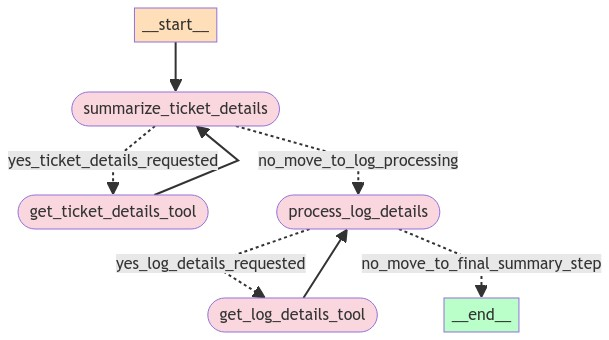

In [8]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### Langsmith Tracing 

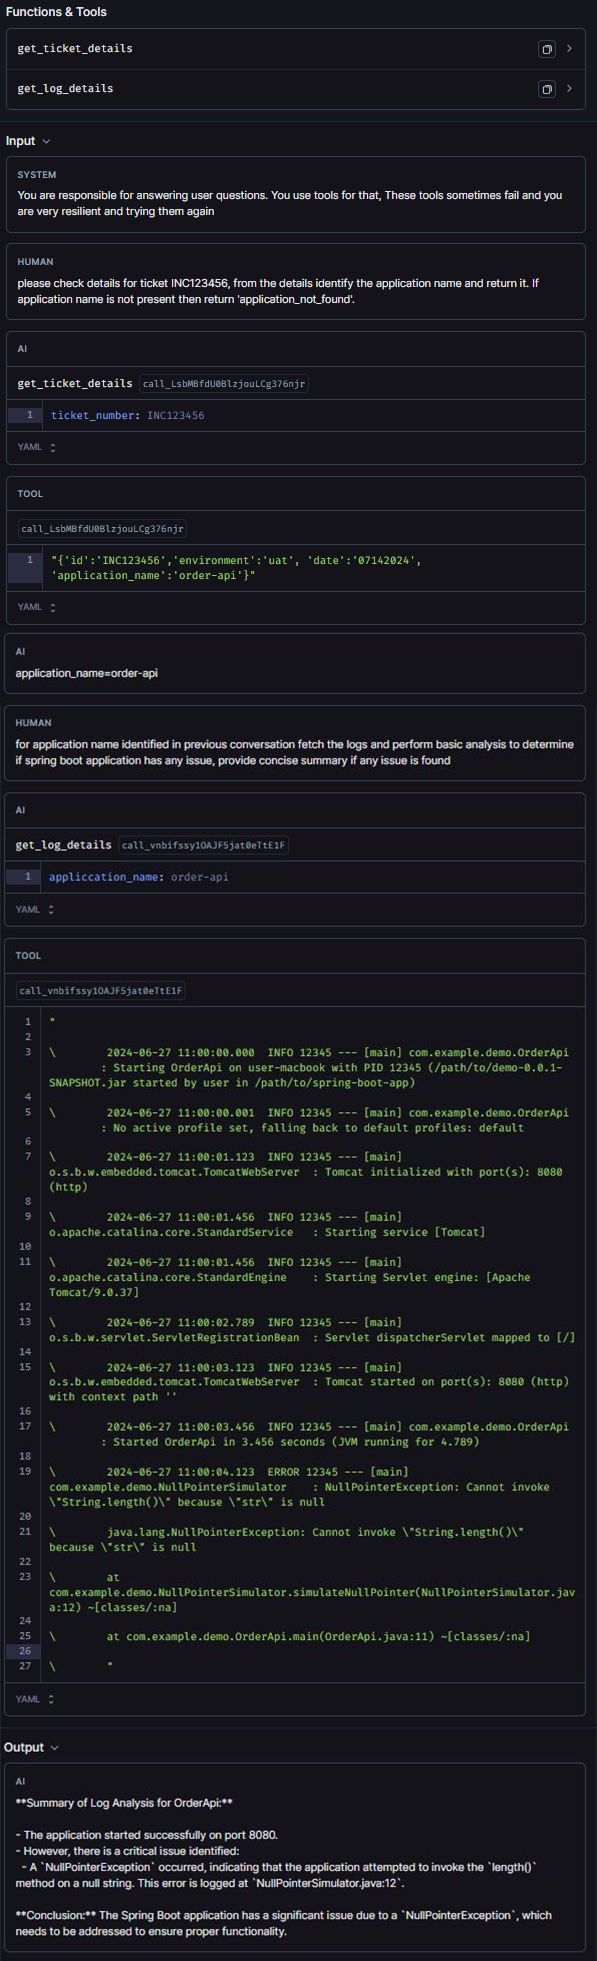

In [13]:
from IPython.display import Image
Image(filename='../../langsmith-tracing.JPG') 